### Exercise 1

![Image Title](assignment2.png)


In this assignment you will use the same imbalanced data set taken from MNIST as you did in 
Assignment #1. The t-SNE’d version of a randomy different version of similar data is shown above.
For this assignment you will
1) implement your own version of the Fuzzy C-Means clustering algorithm, “from scratch”.
2) you will apply this to both the dataset in the file (with 784 dimensions), as well as a PCA’d version of 
the data where you’ve reduced the dimensionality down to 2.
3) you will then write your own version of the Adjusted Rand Index algorithm (from scratch), and use it 
to score the results of your clustering on both versions of the data.
NOTE: you do not need to write PCA from scratch.
You will turn in both the code and a short report, discussing what you’ve implemented, how well it 
worked, what you’ve learned, etc. Remember, you must understand what you turn in – you may be 
asked to explain it to me and/or the class.
NOTE: Do not just comment your code and then turn that in as your report. I will deduct points. Your 
report will usually have at least a couple of pages of text, figures, etc

In [13]:
from bidict import bidict
from datetime import datetime
import numpy as np
from scipy.spatial import distance
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
from sklearn import datasets, metrics

google = False
data_path = 'G:/My Drive/csc730'

In [14]:
# %matplotlib qt

In [15]:
if google == True:
    from google.colab import drive
    drive.mount('/content/drive')
    !ls "/content/drive/"

In [16]:
X_y = np.load('../data/skewed_MNIST.npy')
X = X_y[:,:-1]
y = X_y[:,-1]
print(X.shape,y.shape)

(12244, 784) (12244,)


probability=array([0.01559948, 0.00187847, 0.03128063, 0.50073505, 0.25032669,
       0.0077589 , 0.06256125, 0.0008984 , 0.00383861, 0.12512251]) bins=array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]) counts=array([ 191,   23,  383, 6131, 3065,   95,  766,   11,   47, 1532],
      dtype=int64)


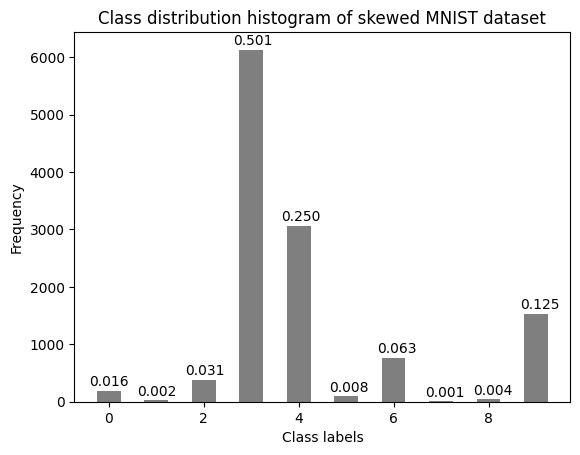

In [17]:
#original
#plt.hist(y)
#plt.xlabel('Class labels')
#plt.ylabel('frequency')

#modified qqqxxx
plt.hist(y, bins=np.linspace(0,10,11), align='left', rwidth=0.5, color='black', alpha=0.5)
plt.xlabel('Class labels')
plt.ylabel('Frequency')
plt.title('Class distribution histogram of skewed MNIST dataset')

probability, bins = np.histogram(y, bins=np.linspace(0,10,11), density=True)
counts, bins = np.histogram(y, bins=np.linspace(0,10,11))

print(f'{probability=} {bins=} {counts=}')

for i in range(len(probability)):
    plt.text(bins[i]+i/100, counts[i]+30, f'{probability[i]:.3f}', ha='center', va='bottom')

plt.savefig('class_histogram.png', dpi=300)
plt.show()


Implement fuzzy-cmeans from scratch

The paper this will be implmented from is titled: 'A Survey of Clustering Algorithms for Big Data: Taxonomy and Empirical Analysis'


[1]  
FCM pseudo-code:  
Input: Given the dataset, set the desire number of clusters c, the fuzzy parameter m (a constant > 1), and the stopping condition, initialize the fuzzy partition matrix, and set stop = false.  
Step 1. Do:  
Step 2. Calculate the cluster centroids and the objective value J.  
Step 3. Compute the membership values stored in the matrix.  
Step 4. If the value of J between consecutive iterations is less than the stopping condition, then stop = true.  
Step 5. While (!stop)  
Output: A list of c cluster centres and a partition matrix are produced.  
  
References:
[1] Fahad, A., Alshatri, N., Tari, Z., Alamri, A., Khalil, I., Zomaya, A. Y., ... & Bouras, A. (2014). A survey of clustering algorithms for big data: Taxonomy and empirical analysis. IEEE transactions on emerging topics in computing, 2(3), 267-279.

In [18]:
# Implment fuzzy c-means clustering from scratch

def fcm(X, n_clusters, max_iter=100, m=2, error=1e-5, random_state=42):
    """
    Fuzzy c-means clustering algorithm
    :param X: array of shape (n_samples, n_features)
    :param n_clusters: number of clusters
    :param max_iter: maximum number of iterations
    :param m: fuzziness parameter
    :param error: tolerance error
    :param random_state: random seed
    :return: array of shape (n_samples, n_clusters) with membership probabilities
    """
    np.random.seed(random_state)
    # initialize membership matrix
    U = np.random.rand(X.shape[0], n_clusters)
    U = U / np.tile(U.sum(axis=1)[np.newaxis].T, n_clusters)
    # iterate
    for iteration in range(max_iter):
        # calculate cluster centers
        C = U.T.dot(X) / U.sum(axis=0)[:, np.newaxis]
        # calculate distance matrix
        D = squareform(pdist(X, metric='euclidean'))
        # update membership matrix
        U_new = np.power(D, -2 / (m - 1)) / np.tile(np.power(D, -2 / (m - 1)).sum(axis=1)[np.newaxis].T, n_clusters)
        # check convergence
        if np.linalg.norm(U - U_new) < error:
            break
        U = U_new
    return U




In [19]:
#Apply fuzzy c-means this to both the dataset in the file (with 784 dimensions), as well as a PCA’d version of the data where you’ve reduced the dimensionality down to 2.
#we can use the PCA function from sklearn.decomposition to reduce the dimensionality of the data down to 2 dimensions.
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
print(X_pca.shape)

#plot the results of the clustering on the original data and the PCA’d data, and compare the results.

full_D = fcm(X, 10, max_iter=100, m=2, error=1e-5, random_state=42)
pca_D = fcm(X_pca, 10, max_iter=100, m=2, error=1e-5, random_state=42)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=full_D.argmax(axis=1), cmap='rainbow')
plt.title('Original data')
plt.subplot(1, 2, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=pca_D.argmax(axis=1), cmap='rainbow')
plt.title('PCA data')
plt.savefig('fcm.png', dpi=300)
plt.show()



In [20]:
#you will then write your own version of the Adjusted Rand Index algorithm (from scratch), and use it to score the results of your clustering on both versions of the data.
#The Adjusted Rand Index is a measure of the similarity between two data clusterings, and is often used to compare the results of clustering algorithms to a ground truth clustering.

def adjusted_rand_index(true_labels, pred_labels):
    """
    Adjusted Rand Index
    :param true_labels: array of true labels
    :param pred_labels: array of predicted labels
    :return: adjusted rand index
    """
    # contingency table
    n = len(true_labels)
    true_labels = true_labels.astype(int)
    pred_labels = pred_labels.astype(int)
    cont_table = np.zeros((10, 10))
    for i in range(n):
        cont_table[true_labels[i], pred_labels[i]] += 1
    # calculate adjusted rand index
    a = cont_table.sum(axis=1)
    b = cont_table.sum(axis=0)
    c = np.sum(a * (a - 1)) / 2
    d = np.sum(b * (b - 1)) / 2
    e = np.sum(cont_table * (cont_table - 1)) / 2
    f = (c * d) / ((n * (n - 1)) / 2)
    g = (c + d) / 2
    h = (a * b) / ((n * (n - 1)) / 2)
    ARI = (e - f) / (g - f)
    RI = (e - f) / (h - f)
    return ARI, RI

#use the adjusted_rand_index function to score the results of your clustering on both versions of the data.
ARI_full, RI_full = adjusted_rand_index(y, full_D.argmax(axis=1))
ARI_pca, RI_pca = adjusted_rand_index(y, pca_D.argmax(axis=1))
print(f'ARI of original data: {ARI_full:.3f}')
print(f'ARI of PCA data: {ARI_pca:.3f}')
print(f'RI of original data: {RI_full:.3f}')
print(f'RI of PCA data: {RI_pca:.3f}')


